# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.  We compute "how far behind" a country is from another country by comparing the fraction of the population infected in each country.  As of 2020-03-16, the US is 17 days away from Italy (and increasing, which is good).  Spain however is 4 days away.

# Imports and definitions

In [8]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 12,6
plt.style.use('ggplot')
pd.options.display.max_columns = 300

# Load data

In [113]:
# define paths to each raw file
d_ts = {}
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [114]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    return dfp_melt

In [115]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')

metric: confirmed at 2020-03-17 18:23:54.284941
metric: deaths at 2020-03-17 18:23:55.302291
metric: recovered at 2020-03-17 18:23:56.291195


In [116]:
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

Latest data from 2020-03-17


In [117]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   'recovered': np.sum,
               }))

##### Top 10 countries by confirmed COVID-19 cases

In [118]:
# get the top countries
dfp_top_countries = dfp_country.groupby(['country'], as_index=False).agg({'confirmed': np.max})
dfp_top_countries = dfp_top_countries.sort_values(by='confirmed', ascending=0).reset_index(drop=True)
dfp_top_countries.head(10)

,country,confirmed
0,China,81058.0
1,Italy,31506.0
2,Iran,16169.0
3,Spain,11748.0
4,Germany,9257.0
5,"Korea, South",8320.0
6,France,7683.0
7,US,6421.0
8,Switzerland,2700.0
9,United Kingdom,1960.0


# Plot the infections for the top countries

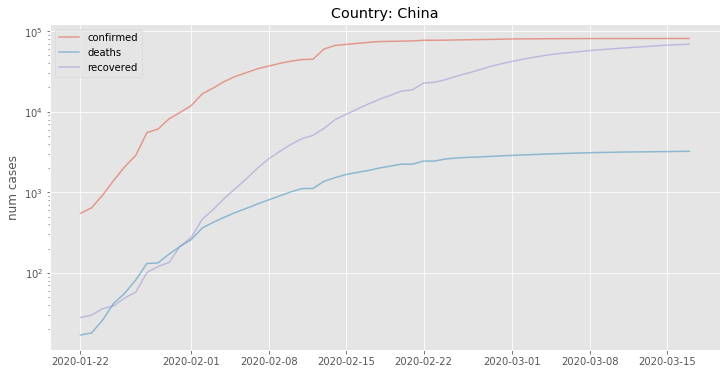

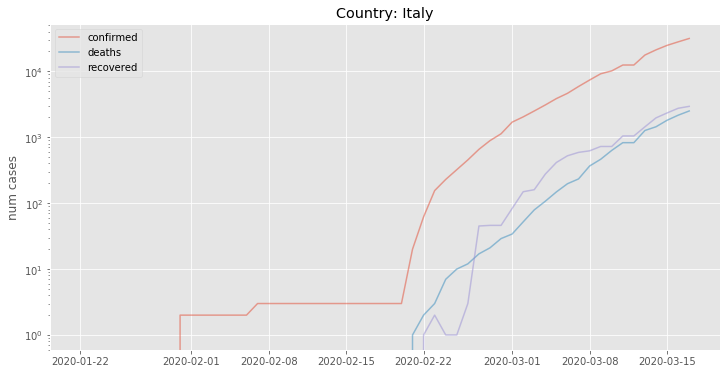

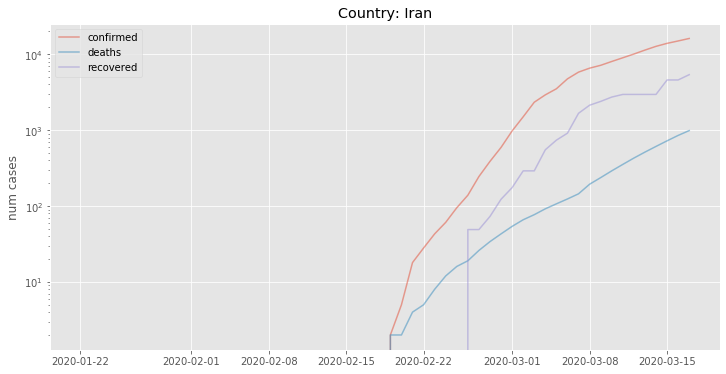

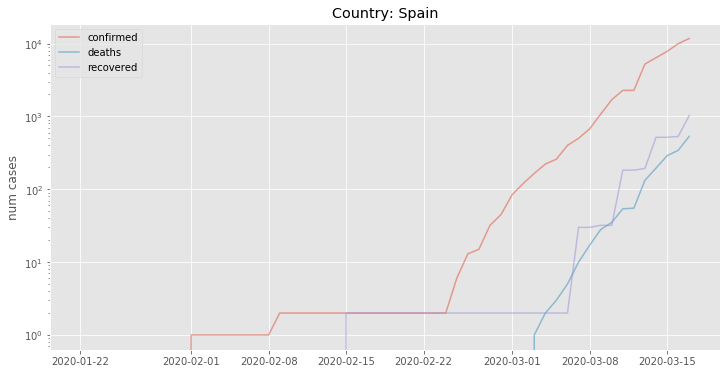

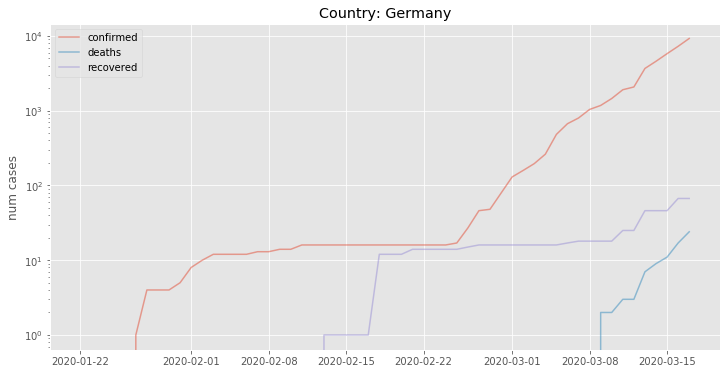

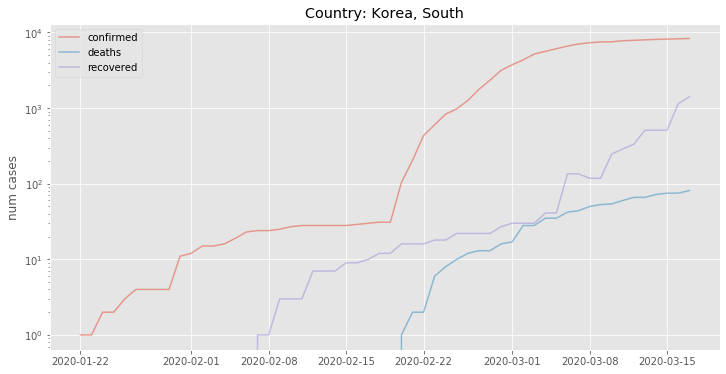

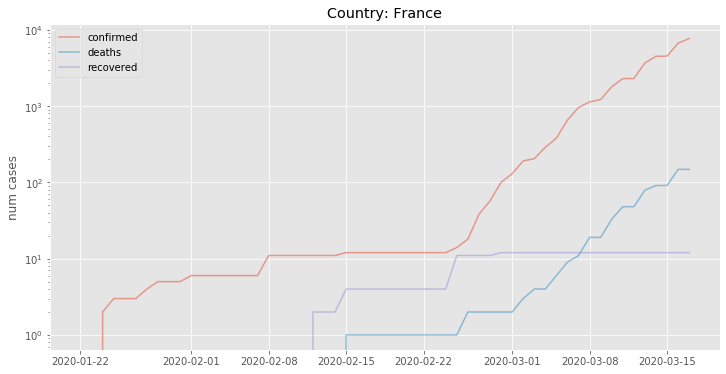

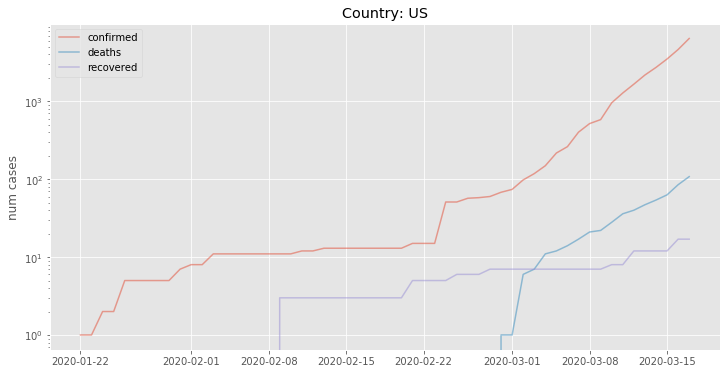

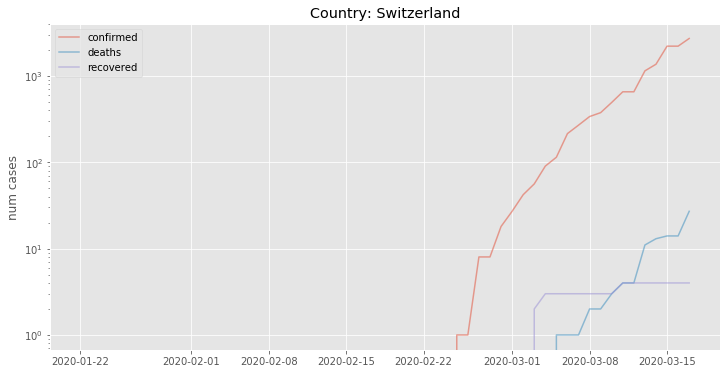

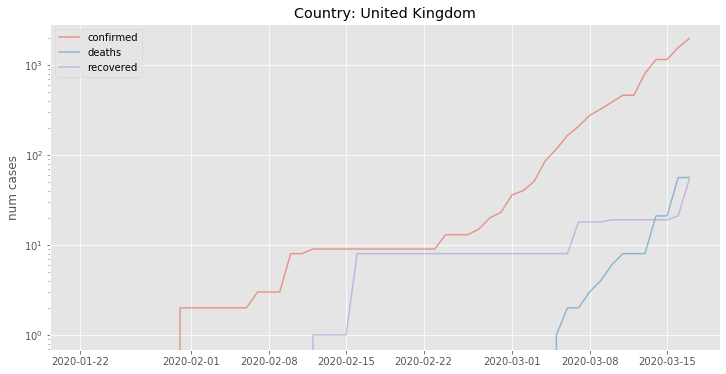

In [119]:
# plot the top countries
for country in dfp_top_countries.iloc[:10]['country']:
    dfp_plot = dfp_country[dfp_country['country'] == country]
    for key in d_data.keys():
        plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, label=key)
    plt.legend(loc='best')
    plt.ylabel('num cases')
    plt.title(f'Country: {country}')
    plt.yscale('log')
    plt.show()

# Normalize infections by population

Population data taken from https://www.worldometers.info/world-population/population-by-country/ on 2020-03-16

In [121]:
dfp_world_pop = pd.read_csv('supporting_data/country_population_data.csv')

In [122]:
# clean population data
dfp_world_pop = dfp_world_pop.rename(columns={
    'Country (or dependency)': 'country', 
    'Population\n (2020)': 'population'
})
dfp_world_pop['population'] = dfp_world_pop['population'].apply(lambda x: float(x.replace(',', '')))

In [123]:
translations = {'South Korea': 'Korea, South',
                'United States': 'US',
               }
for old, new in translations.items():
    try:
        dfp_world_pop['country'][np.where(dfp_world_pop['country'] == old)[0][0]] = new
    except Exception as e:
        pass  #print(e)

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [124]:
# filter in only the top countries
top_n = 10
pop_cols = ['country', 'population']
dfp_country_top = dfp_country.merge(dfp_top_countries.iloc[:top_n]['country'], on='country', how='inner')
dfp_country_top_dec = dfp_country_top.merge(dfp_world_pop[pop_cols], on='country', how='left')
dfp_country_top_dec['confirmed_frac'] = dfp_country_top_dec['confirmed'] / dfp_country_top_dec['population']
dfp_country_top_dec['deaths_frac'] = dfp_country_top_dec['deaths'] / dfp_country_top_dec['population']

# How many days behind is each country?

In [125]:
def days_behind(
    country_compare, 
    country_base, 
    dfp=dfp_country_top_dec, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_compare, country_base]
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)

        plt.plot(dfp_p['date'], dfp_p['confirmed'], alpha=0.5, label=country)

        list_dfp_compare.append(dfp_p)
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    
    dfp_comp = list_dfp_compare[1]
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for i, row in list_dfp_compare[0][:n_days].iterrows():
        dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
        min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
        #print(row['date'] - dfp_comp[min_loc]['date'])
        days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
        row['days_diff'] = days_diff
        list_series.append(row)

    # plot days behind
    dfp_days_behind = pd.concat(list_series, axis=1).T
    plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'])
    mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
    date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.title(f'Days behind: {country_compare} is {mean_days_diff:0.2f} days behind {country_base} as of {date_max}')
    plt.ylabel('# days')
    plt.show()
    return dfp_days_behind

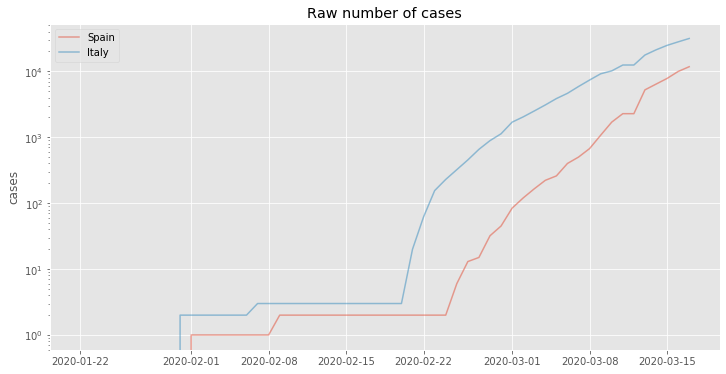

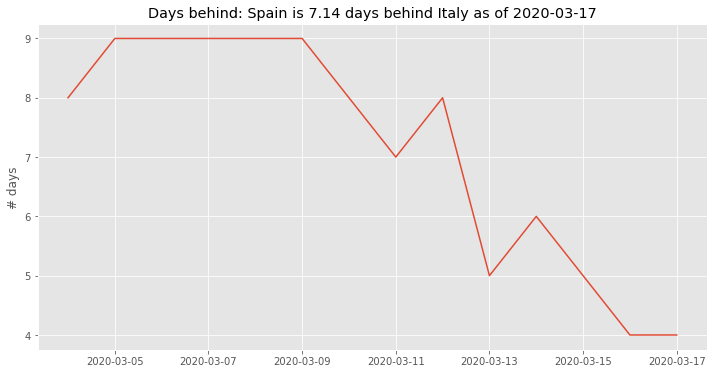

In [126]:
_ = days_behind('Spain', 'Italy')

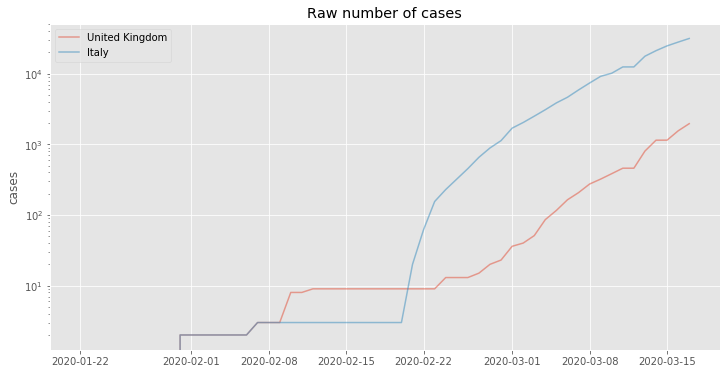

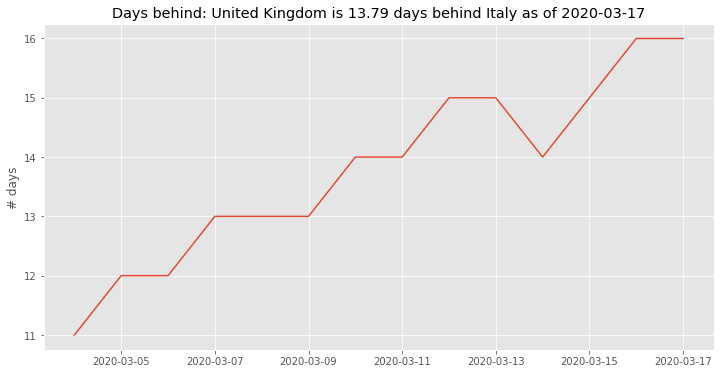

In [127]:
_ = days_behind('United Kingdom', 'Italy')

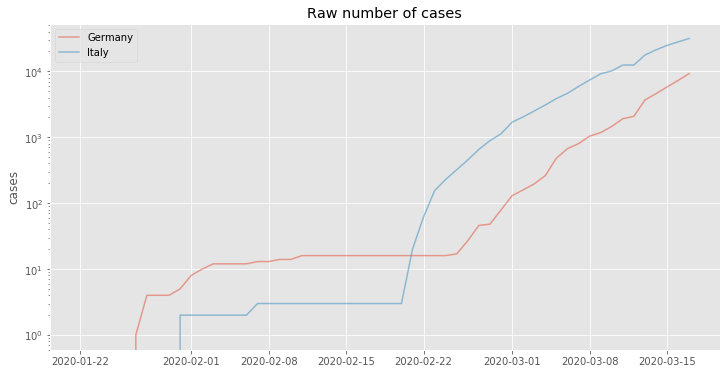

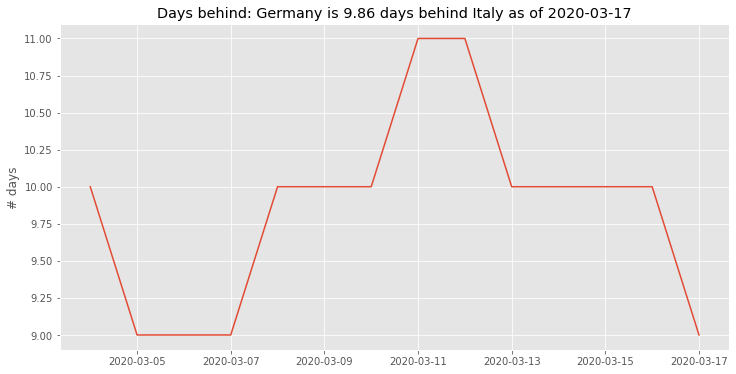

In [128]:
_ = days_behind('Germany', 'Italy')

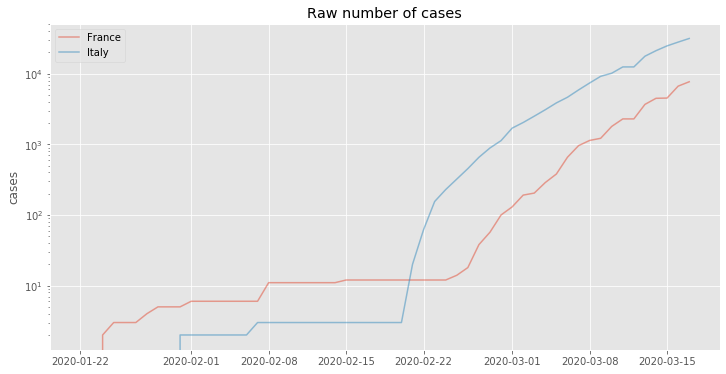

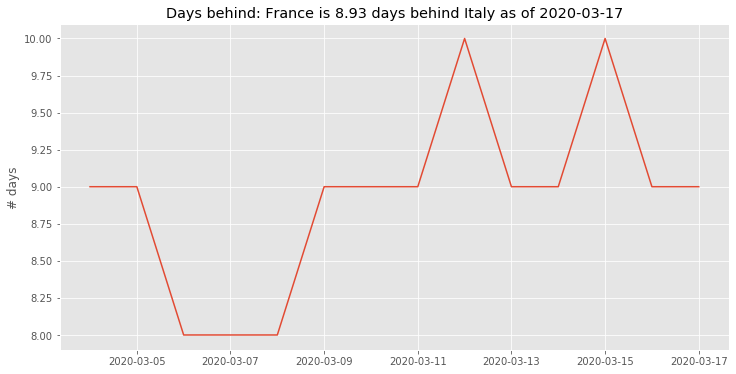

In [129]:
_ = days_behind('France', 'Italy')

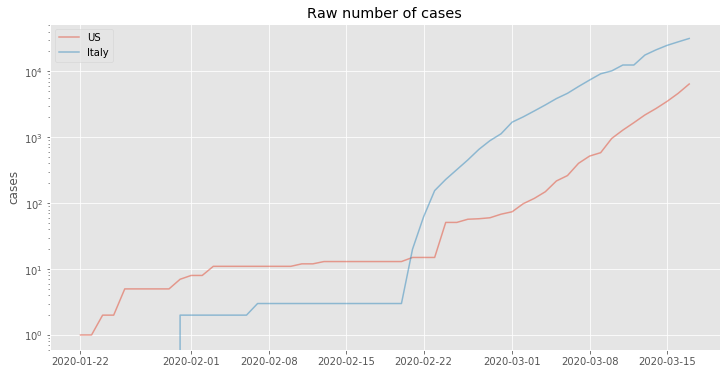

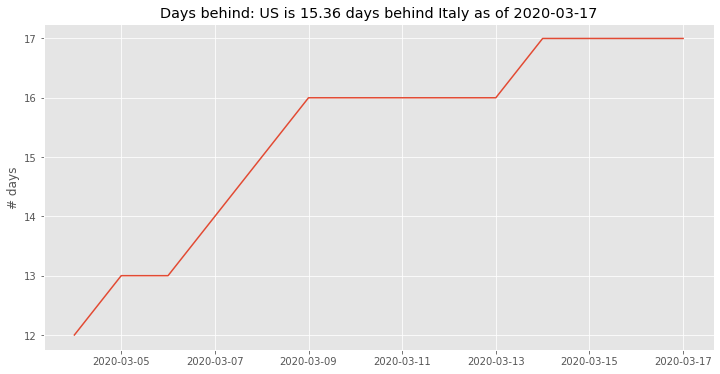

In [130]:
_ = days_behind('US', 'Italy')

##### Compare raw cases for US/Italy

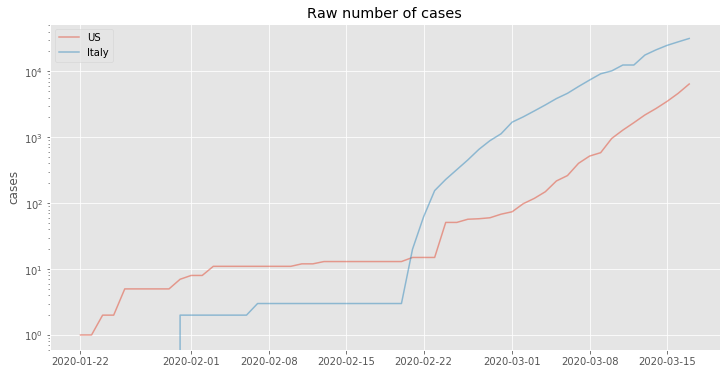

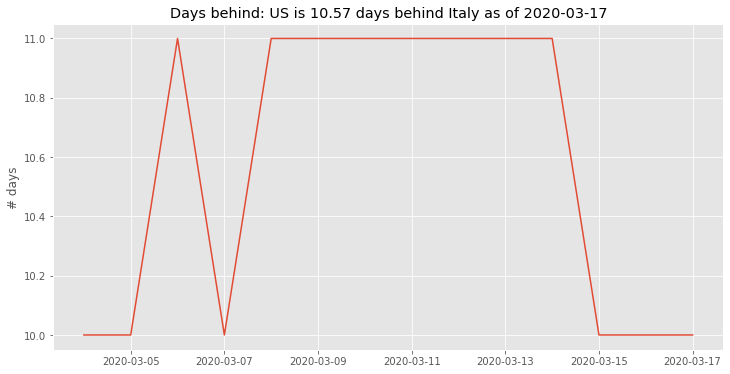

In [131]:
_ = days_behind('US', 'Italy', compare_col='confirmed')

# US state breakdown

In [132]:
# look only at the US
dfp_us_raw = dfp[dfp['country'] == 'US']
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [133]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                'recovered': np.sum,
               })
           )

##### Unique states after data cleaning

In [134]:
dfp_us['state_clean'].unique()

array(['Washington', 'New York', 'California', 'Massachusetts',
       'Diamond Princess', 'Grand Princess', 'Georgia', 'Colorado',
       'Florida', 'New Jersey', 'Oregon', 'Texas', 'Illinois',
       'Pennsylvania', 'Iowa', 'Maryland', 'North Carolina',
       'South Carolina', 'Tennessee', 'Virginia', 'Arizona', 'Indiana',
       'Kentucky', 'District of Columbia', 'Nevada', 'New Hampshire',
       'Minnesota', 'Nebraska', 'Ohio', 'Rhode Island', 'Wisconsin',
       'Connecticut', 'Hawaii', 'Oklahoma', 'Utah', 'Kansas', 'Louisiana',
       'Missouri', 'Vermont', 'Alaska', 'Arkansas', 'Delaware', 'Idaho',
       'Maine', 'Michigan', 'Mississippi', 'Montana', 'New Mexico',
       'North Dakota', 'South Dakota', 'West Virginia', 'Wyoming',
       'Washington, D.C.', 'Alabama', 'Puerto Rico', 'Guam',
       'Virgin Islands'], dtype=object)

##### States with the most infections

In [135]:
dfp_us_top_states = (dfp_us_g.groupby(['state_clean'], as_index=False).
                     agg({'confirmed': np.max}).
                     sort_values(by='confirmed', ascending=0).
                     reset_index(drop=True)
                    )
dfp_us_top_states.head(5)

,state_clean,confirmed
0,New York,1706.0
1,Washington,1076.0
2,California,698.0
3,New Jersey,267.0
4,Massachusetts,218.0


##### Plot of infections in top 3 states

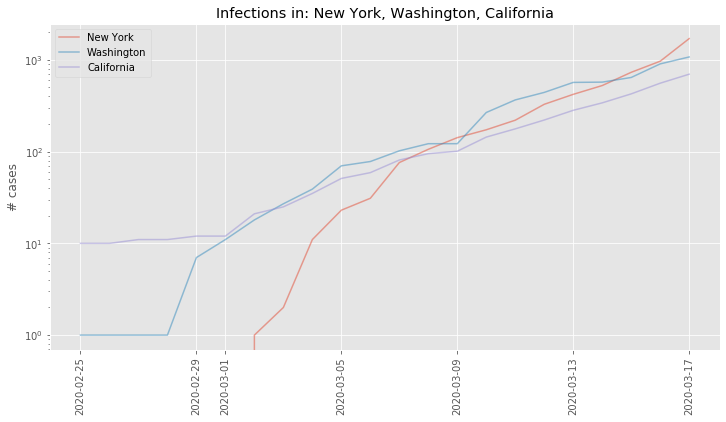

In [136]:
#states_oi = ['Washington', 'New York', 'California']
states_oi = dfp_us_top_states.iloc[:3]['state_clean'].values
plot_col = 'confirmed'
date_min = datetime.datetime(2020, 2, 25)
for state in states_oi:
    dfp_s = dfp_us_g[(dfp_us_g['state_clean'] == state) & (dfp_us_g['date'] >= date_min)]
    plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
plt.ylabel('# cases')
plt.xticks(rotation=90)
plt.title(f'Infections in: {", ".join(states_oi)}')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

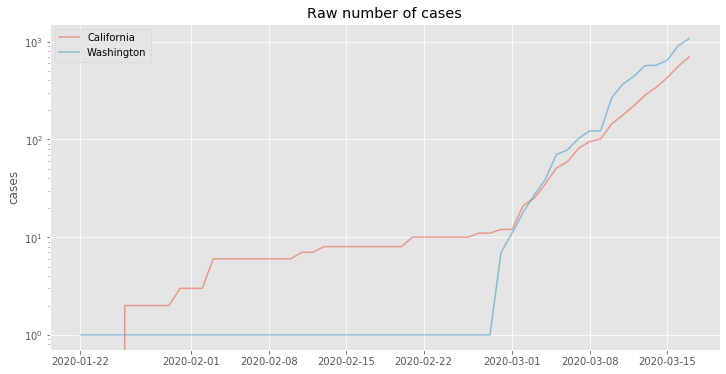

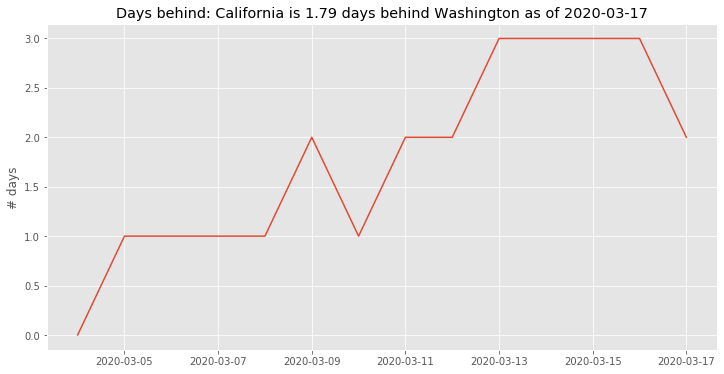

In [137]:
_ = days_behind('California', 'Washington', dfp=dfp_us_g, country_col='state_clean', compare_col='confirmed')

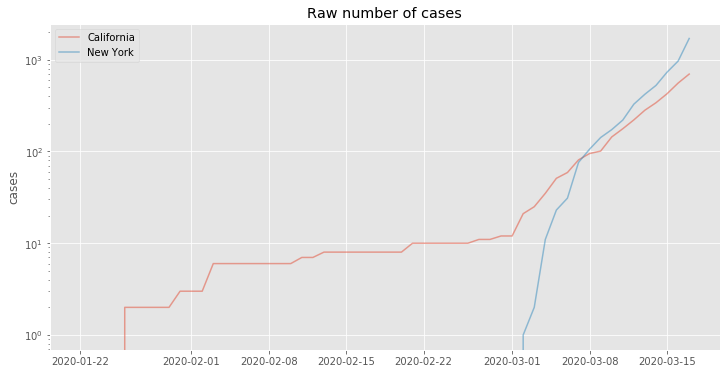

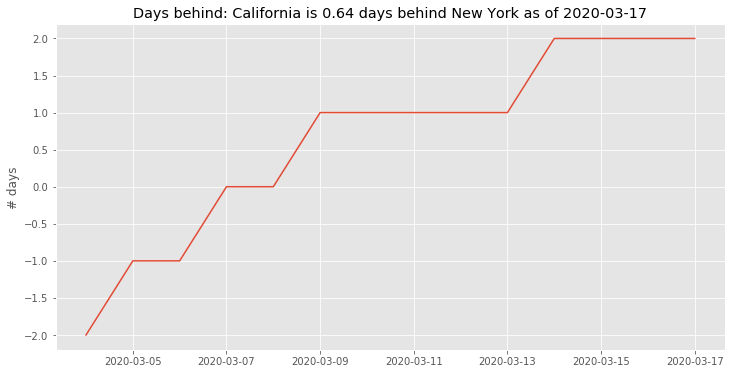

In [138]:
_ = days_behind('California', 'New York', dfp=dfp_us_g, country_col='state_clean', compare_col='confirmed')